In [1]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [2]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [3]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import geopandas as gpd

# hide
# no_test
import geowrangler.grids as grids

/home/butchtm/work/geomaint/wrkwrangler/.venv/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Spatial Join Using Highest Intersection Tutorial

> A basic introduction to using spatial join using highest intersection

## Summary
Joins attributes of two tables based on largest area of overlap. Usage of this function assumes that the two datasets are both vector polygon data.

## How does it work? 
Spatial join using highest intersection works by assigning a unique ID to the first dataframe (gdf1) and using its geometry as basis for the intersection. Data from the second dataframe (gdf2), apart from its geometry, is retained in the output. 

### `get_highest_intersection (gdf1, gdf2, proj_crs)`

|  | type | default | optional/ required | details |
| --- | :--- | :--- | :--- | :--- |
| gdf1 | GeoDataFrame | *none* | required | basis of output geometry |
| gdf2 | GeoDataFrame | *none* | required | data to be included during intersection |
| proj_crs | String | *none* | required | metric CRS (e.g., Philippines uses EPSG:32651) |

A technical step-by-step explanation of how `get_highest_intersection` works is detailed in the cell blocks below. An example on how to use it with its arguments is shown in the **sample use case** section thereafter. 

1) Define the function and its arguments.

```
def get_highest_intersection(
    gdf1: gpd.GeoDataFrame,
    gdf2: gpd.GeoDataFrame,
    proj_crs: str,
) -> gpd.GeoDataFrame:
```

2) Create a copy of the two geodataframes. 

```
    gdf1 = gdf1.copy()
    gdf2 = gdf2.copy()
```

3) Rename new columns with "__" prefixes and suffixes to prevent overwriting existing columns in the original geodataframes.

```
    uid_col = "__uid__"
    area_col = "__area_highest_intersection__"
    auxiliary_cols = [uid_col, area_col]
```

4) Conduct checks to make sure we are not overwriting existing columns. 

```
    for col in auxiliary_cols:
        if col in gdf1.columns:
            raise ValueError(f"Make sure {col} isn't already a column in gdf1")
        if col in gdf2.columns:
            raise ValueError(f"Make sure {col} isn't already a column in gdf2")
```

5) Assign a unique ID to the first geodataframe. *Note that uid_col is also defined in Step 2.* 

```
    gdf1[uid_col] = range(len(gdf1))
```

6) Get intersection of the geodataframes.

```
    overlay = gdf1.overlay(gdf2, how="intersection")
```

7) Add a column for overlapping area. *Note that area_col is also defined in Step 2.*

```
    overlay["geometry"] = overlay["geometry"].to_crs(proj_crs)
    overlay[area_col] = (overlay.geometry.area)
```

8) Sort values by area. Drop duplicates and null values.

```
    overlay = overlay.sort_values(by=area_col, ascending=True)
    overlay = overlay.drop_duplicates(subset=[uid_col], keep="last")
    overlay = overlay.dropna(subset=[uid_col])
    assert not overlay[uid_col].duplicated().any()
    overlay = overlay.sort_values(by=[uid_col], ascending=True)
```

9) Drop geometry from the overlay dataframe and merge the original geometry from gdf1. Also drop additional columns (uid_col, area_col) used to accomplish calculate overlapping area for the function. 

```
    overlay_merge = overlay.drop("geometry", axis=1)

    output = pd.merge(
        left=gdf1[[uid_col, "geometry"]],
        right=overlay_merge,
        on=uid_col,
        how="left",
        validate="one_to_one",
    )

    output = output.drop(columns=auxiliary_cols)
```

10) Drop the additional columns (uid_col, area_col) and return the final output. 

```
    return output
```

## Sample use case - Labeling grid with administrative boundaries

Input:
  - `grid` - GeoDataFrame that will become the basis of geometries for the output
  - `adm_bounds` - GeoDataFrame containing attributes that we want to append to the grid
  - `proj_crs` - metric coordinate reference system (e.g., "EPSG:32651" for the Philippines)

Output
  - grid with one province name per cell

In [5]:
# hide
import warnings

from IPython.display import display

warnings.filterwarnings("ignore", category=UserWarning, module="geopandas")

### Step 1: Import package

In [6]:
import geopandas as gpd
import geowrangler.grids as grids

In [7]:
import geowrangler.spatialjoin_highest_intersection as spatial_join

### Step 2: Load the first dataset (grid)
This dataset will become the basis of geometry for the output.

In [8]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson files from repo
![ ! -e ../data/geoboundary.geojson ] && curl -s -o ../data/geoboundary.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/geoboundary.geojson

In [9]:
# hide
admin_bounds = gpd.read_file("../data/geoboundary.geojson")

In [10]:
# hide
grid_generator5k = grids.SquareGridGenerator(50_000)
grid = grid_generator5k.generate_grid(admin_bounds)

In [11]:
grid

,x,y,geometry
0,3,3,"POLYGON ((118.27581 5.92871, 118.72497 5.92871..."
1,2,3,"POLYGON ((117.82665 5.92871, 118.27581 5.92871..."
2,3,4,"POLYGON ((118.27581 6.37528, 118.72497 6.37528..."
3,3,5,"POLYGON ((118.27581 6.82146, 118.72497 6.82146..."
4,0,6,"POLYGON ((116.92834 7.26723, 117.37749 7.26723..."
...,...,...,...
318,19,1,"POLYGON ((125.46233 5.03451, 125.91149 5.03451..."
319,19,12,"POLYGON ((125.46233 9.93163, 125.91149 9.93163..."
320,19,13,"POLYGON ((125.46233 10.37375, 125.91149 10.373..."
321,20,12,"POLYGON ((125.91149 9.93163, 126.36065 9.93163..."


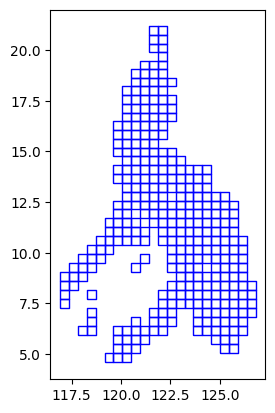

In [12]:
grid.plot(facecolor="none", edgecolor="blue");

In [13]:
# grid.explore()

### Step 3: Load the second dataset (admin_bounds)
Info from this dataset (apart from geometry) will be appended to the output based on highest spatial intersection.

In [14]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson files from repo
![ ! -e ../data/geoboundary.geojson ] && curl -s -o ../data/geoboundary.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/geoboundary.geojson

In [15]:
# hide
admin_bounds = gpd.read_file("../data/geoboundary.geojson")

In [16]:
admin_bounds

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,Abra,None,PHL-ADM2-3_0_0-B1,PHL,ADM2,"MULTIPOLYGON (((120.96795 17.95706, 120.97803 ..."
1,Agusan del Norte,None,PHL-ADM2-3_0_0-B2,PHL,ADM2,"MULTIPOLYGON (((125.57724 9.45679, 125.59687 9..."
2,Agusan del Sur,None,PHL-ADM2-3_0_0-B3,PHL,ADM2,"MULTIPOLYGON (((125.91087 8.85625, 125.91461 8..."
3,Aklan,None,PHL-ADM2-3_0_0-B4,PHL,ADM2,"MULTIPOLYGON (((122.43667 11.59833, 122.43667 ..."
4,Albay,None,PHL-ADM2-3_0_0-B5,PHL,ADM2,"MULTIPOLYGON (((123.28764 13.04923, 123.28686 ..."
...,...,...,...,...,...,...
76,Tawi-Tawi,None,PHL-ADM2-3_0_0-B77,PHL,ADM2,"MULTIPOLYGON (((119.46694 4.58694, 119.46639 4..."
77,Zambales,None,PHL-ADM2-3_0_0-B78,PHL,ADM2,"MULTIPOLYGON (((120.08285 14.75048, 120.08222 ..."
78,Zamboanga del Norte,None,PHL-ADM2-3_0_0-B79,PHL,ADM2,"MULTIPOLYGON (((122.09467 7.53152, 122.09467 7..."
79,Zamboanga del Sur,None,PHL-ADM2-3_0_0-B80,PHL,ADM2,"MULTIPOLYGON (((122.06223 6.87278, 122.06250 6..."


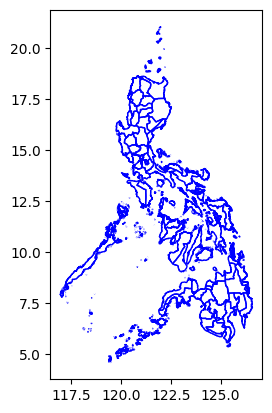

In [17]:
admin_bounds.plot(facecolor="none", edgecolor="blue");

In [18]:
# admin_bounds.explore()

### Step 4: Get spatial join with highest intersection

In [19]:
output = spatial_join.get_highest_intersection(grid, admin_bounds, "EPSG:32651")

> Note that each grid now has admin bounds columns (shapeName, shapeISO, shapeID, ... etc.) based on the intersection with the admin boundaries with the highest overlapping area over each grid.

In [20]:
output

,geometry,x,y,shapeName,shapeISO,shapeID,shapeGroup,shapeType
0,"POLYGON ((118.27581 5.92871, 118.72497 5.92871...",3,3,Tawi-Tawi,None,PHL-ADM2-3_0_0-B77,PHL,ADM2
1,"POLYGON ((117.82665 5.92871, 118.27581 5.92871...",2,3,Tawi-Tawi,None,PHL-ADM2-3_0_0-B77,PHL,ADM2
2,"POLYGON ((118.27581 6.37528, 118.72497 6.37528...",3,4,Tawi-Tawi,None,PHL-ADM2-3_0_0-B77,PHL,ADM2
3,"POLYGON ((118.27581 6.82146, 118.72497 6.82146...",3,5,Tawi-Tawi,None,PHL-ADM2-3_0_0-B77,PHL,ADM2
4,"POLYGON ((116.92834 7.26723, 117.37749 7.26723...",0,6,Palawan,None,PHL-ADM2-3_0_0-B59,PHL,ADM2
...,...,...,...,...,...,...,...,...
318,"POLYGON ((125.46233 5.03451, 125.91149 5.03451...",19,1,Davao del Sur,None,PHL-ADM2-3_0_0-B28,PHL,ADM2
319,"POLYGON ((125.46233 9.93163, 125.91149 9.93163...",19,12,Dinagat Islands,None,PHL-ADM2-3_0_0-B30,PHL,ADM2
320,"POLYGON ((125.46233 10.37375, 125.91149 10.373...",19,13,Eastern Samar,None,PHL-ADM2-3_0_0-B31,PHL,ADM2
321,"POLYGON ((125.91149 9.93163, 126.36065 9.93163...",20,12,Surigao del Norte,None,PHL-ADM2-3_0_0-B74,PHL,ADM2


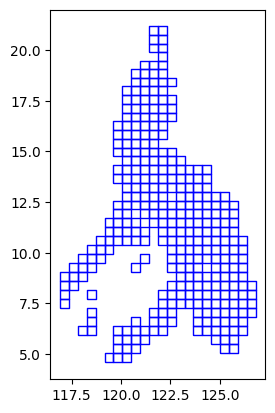

In [23]:
output.plot(facecolor="none", edgecolor="blue");

In [22]:
# output.explore()